[![Works with Edge Impulse](https://raw.githubusercontent.com/edgeimpulse/notebooks/main/.assets/images/ei-badge.svg)](http://edgeimpulse.com) [![Open in Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/edgeimpulse/notebooks/blob/main/notebooks/generate-dall-e-image-dataset.ipynb)

# Use OpenAI Dall-E to generate an image dataset for image classification
This notebook explores how we can use generative AI to create datasets which don't exist yet. This can be a good starting point for your project if you have not collected or cannot collect the data required. It is important to note the limitations of generative AI still apply here, biases can be introduced through your prompts, results can include "hallucinations" and quality control is important.

This example uses the openai API to call the Dall-E image generation tool, it explores both generation and variation but there are other tools such as editing which could also be useful for augmenting an existing dataset.

We have wrapped this example into a [Transformation Block](https://docs.edgeimpulse.com/docs/edge-impulse-studio/organizations/research-data/creating-a-transformation-block-dataset) (Enterprise Feature) to make it even easier to generate images. Upload to your organisation here: https://github.com/edgeimpulse/example-transform-Dall-E-images


### Local Software Requirements
- Python 3
- Pip package manager
- Jupyter Notebook: https://jupyter.org/install
- pip packages (install with `pip install `*`packagename`*):
    - openai https://pypi.org/project/openai/

In [1]:
! pip install openai

In [2]:
# Imports
import openai
import os
import requests
import sys

# Notebook Imports
from IPython.display import Image
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# If running locally, set HOME dir for your machine
HOME_DIR = f"{os.environ['HOME']}/Documents/GitHub/Generative-AI"
DATASET_PATH = f"{HOME_DIR}/datasets"

import sys
sys.path += [DATASET_PATH]

from support import get_device

device = get_device()


## Set up OpenAI API
First off you will need to set up and Edge Impulse account and create your first project.

You will also need to create an API Key for OpenAI: https://platform.openai.com/docs/api-reference/authentication


In [3]:

# You can set your API key and org as environment variables in your system like this:
# os.environ['OPENAI_API_KEY'] = 'api string'

# Set up OpenAI API key and organization
openai.api_key = os.getenv("OPENAI_API_KEY")

# Set env vars for the relevant model or load from a .env file:
import dotenv
dotenv.load_dotenv()

from openai import OpenAI
client = OpenAI()


### Generate your first image
The API takes in a prompt, number of images and a size


In [4]:
image_prompt = "A webcam image of a human 1m from the camera sitting at a desk showing that they are wearing gloves with their hands up to the camera."

response = client.images.generate(
    model="dall-e-3",
    prompt=image_prompt,
    size="1024x1024",
    quality="standard",
    n=1,
)

print(response.data[0].url)
display(Image(url=response.data[0].url))
    

https://oaidalleapiprodscus.blob.core.windows.net/private/org-BjiaYIjDlL6yZRrXyfRYSbPe/user-VROr7JE1i8xy8xYLEMPmf8pv/img-LwgU0oraR8YExhhRk2AD2pMb.png?st=2025-08-16T04%3A51%3A48Z&se=2025-08-16T06%3A51%3A48Z&sp=r&sv=2024-08-04&sr=b&rscd=inline&rsct=image/png&skoid=8b33a531-2df9-46a3-bc02-d4b1430a422c&sktid=a48cca56-e6da-484e-a814-9c849652bcb3&skt=2025-08-16T05%3A51%3A48Z&ske=2025-08-17T05%3A51%3A48Z&sks=b&skv=2024-08-04&sig=JjVuXKm4MOGwMuviWMx/SBluYUPLrbuj2xRTDBWmgGk%3D


### Generate some variations of this image
The API also has a variations call which takes in an existing images and creates variations of it. This could also be used to modify existing images.

In [5]:
response2 = client.images.create_variation(
  image=requests.get(response.data[0].url).content,
  n=3,
  size="1024x1024"
)
imgs = []
for img in response2.data:
  imgs.append(Image(url=img.url))

display(*imgs)

## Generate a dataset:
Here we are iterate through a number of images and variations to generate a dataset based on the prompts/labels given.

In [6]:
from time import sleep

labels = [{"prompt": "A webcam image of a human 1m from the camera sitting at a desk showing that they are wearing wool gloves with their hands up to the camera.",
          "label": "gloves"},
          {"prompt": "A webcam image of a person 1m from the camera sitting at a desk with their bare hands up to the camera.",
          "label": "no-gloves"}
        ]
output_folder = f"{DATASET_PATH}/generate_dall_e_image_dataset"
base_images_number = 10
variation_per_image = 3
# Check if output directory for noisey files exists and create it if it doesn't
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for option in labels:
    for i in range(base_images_number):
        try:
            response = client.images.generate(
                model="dall-e-3",
                prompt=option["prompt"],
                size="1024x1024",
                quality="standard",
                n=1,
            )
        except Exception as e:
            print(f"Image generation error\n{e}")
        sleep(10) #sleep so we do not exceed rate limits
        try:
            img = response.data[0].url
            with open(f'{output_folder}/{option["label"]}.{img.split("/")[-1]}.png', 'wb+') as f:
                f.write(requests.get(img).content)
            response2 = client.images.create_variation(
              image=requests.get(img).content,
              n=variation_per_image,
              size="1024x1024"
            )
        except Exception as e:
            print(f"Image open error:\n{e}")
        for img in response2.data:
            try:
                with open(f'{output_folder}/{option["label"]}.{img.url.split("/")[-1]}.png', 'wb') as f:
                    f.write(requests.get(img.url).content)
            except Exception as e:
                print(f"Image save error:\n{e}")

Image open error:
Error code: 429 - {'error': {'code': 'rate_limit_exceeded', 'message': 'Rate limit exceeded for images per minute in organization org-BjiaYIjDlL6yZRrXyfRYSbPe. Limit: 5/1min. Current: 6/1min. Please visit https://platform.openai.com/docs/guides/rate-limits to learn how to increase your rate limit.', 'param': None, 'type': 'requests'}}
Image open error:
Error code: 429 - {'error': {'code': 'rate_limit_exceeded', 'message': 'Rate limit exceeded for images per minute in organization org-BjiaYIjDlL6yZRrXyfRYSbPe. Limit: 5/1min. Current: 6/1min. Please visit https://platform.openai.com/docs/guides/rate-limits to learn how to increase your rate limit.', 'param': None, 'type': 'requests'}}
Image open error:
Error code: 429 - {'error': {'code': 'rate_limit_exceeded', 'message': 'Rate limit exceeded for images per minute in organization org-BjiaYIjDlL6yZRrXyfRYSbPe. Limit: 5/1min. Current: 6/1min. Please visit https://platform.openai.com/docs/guides/rate-limits to learn how to

### Plot all the output images:

56


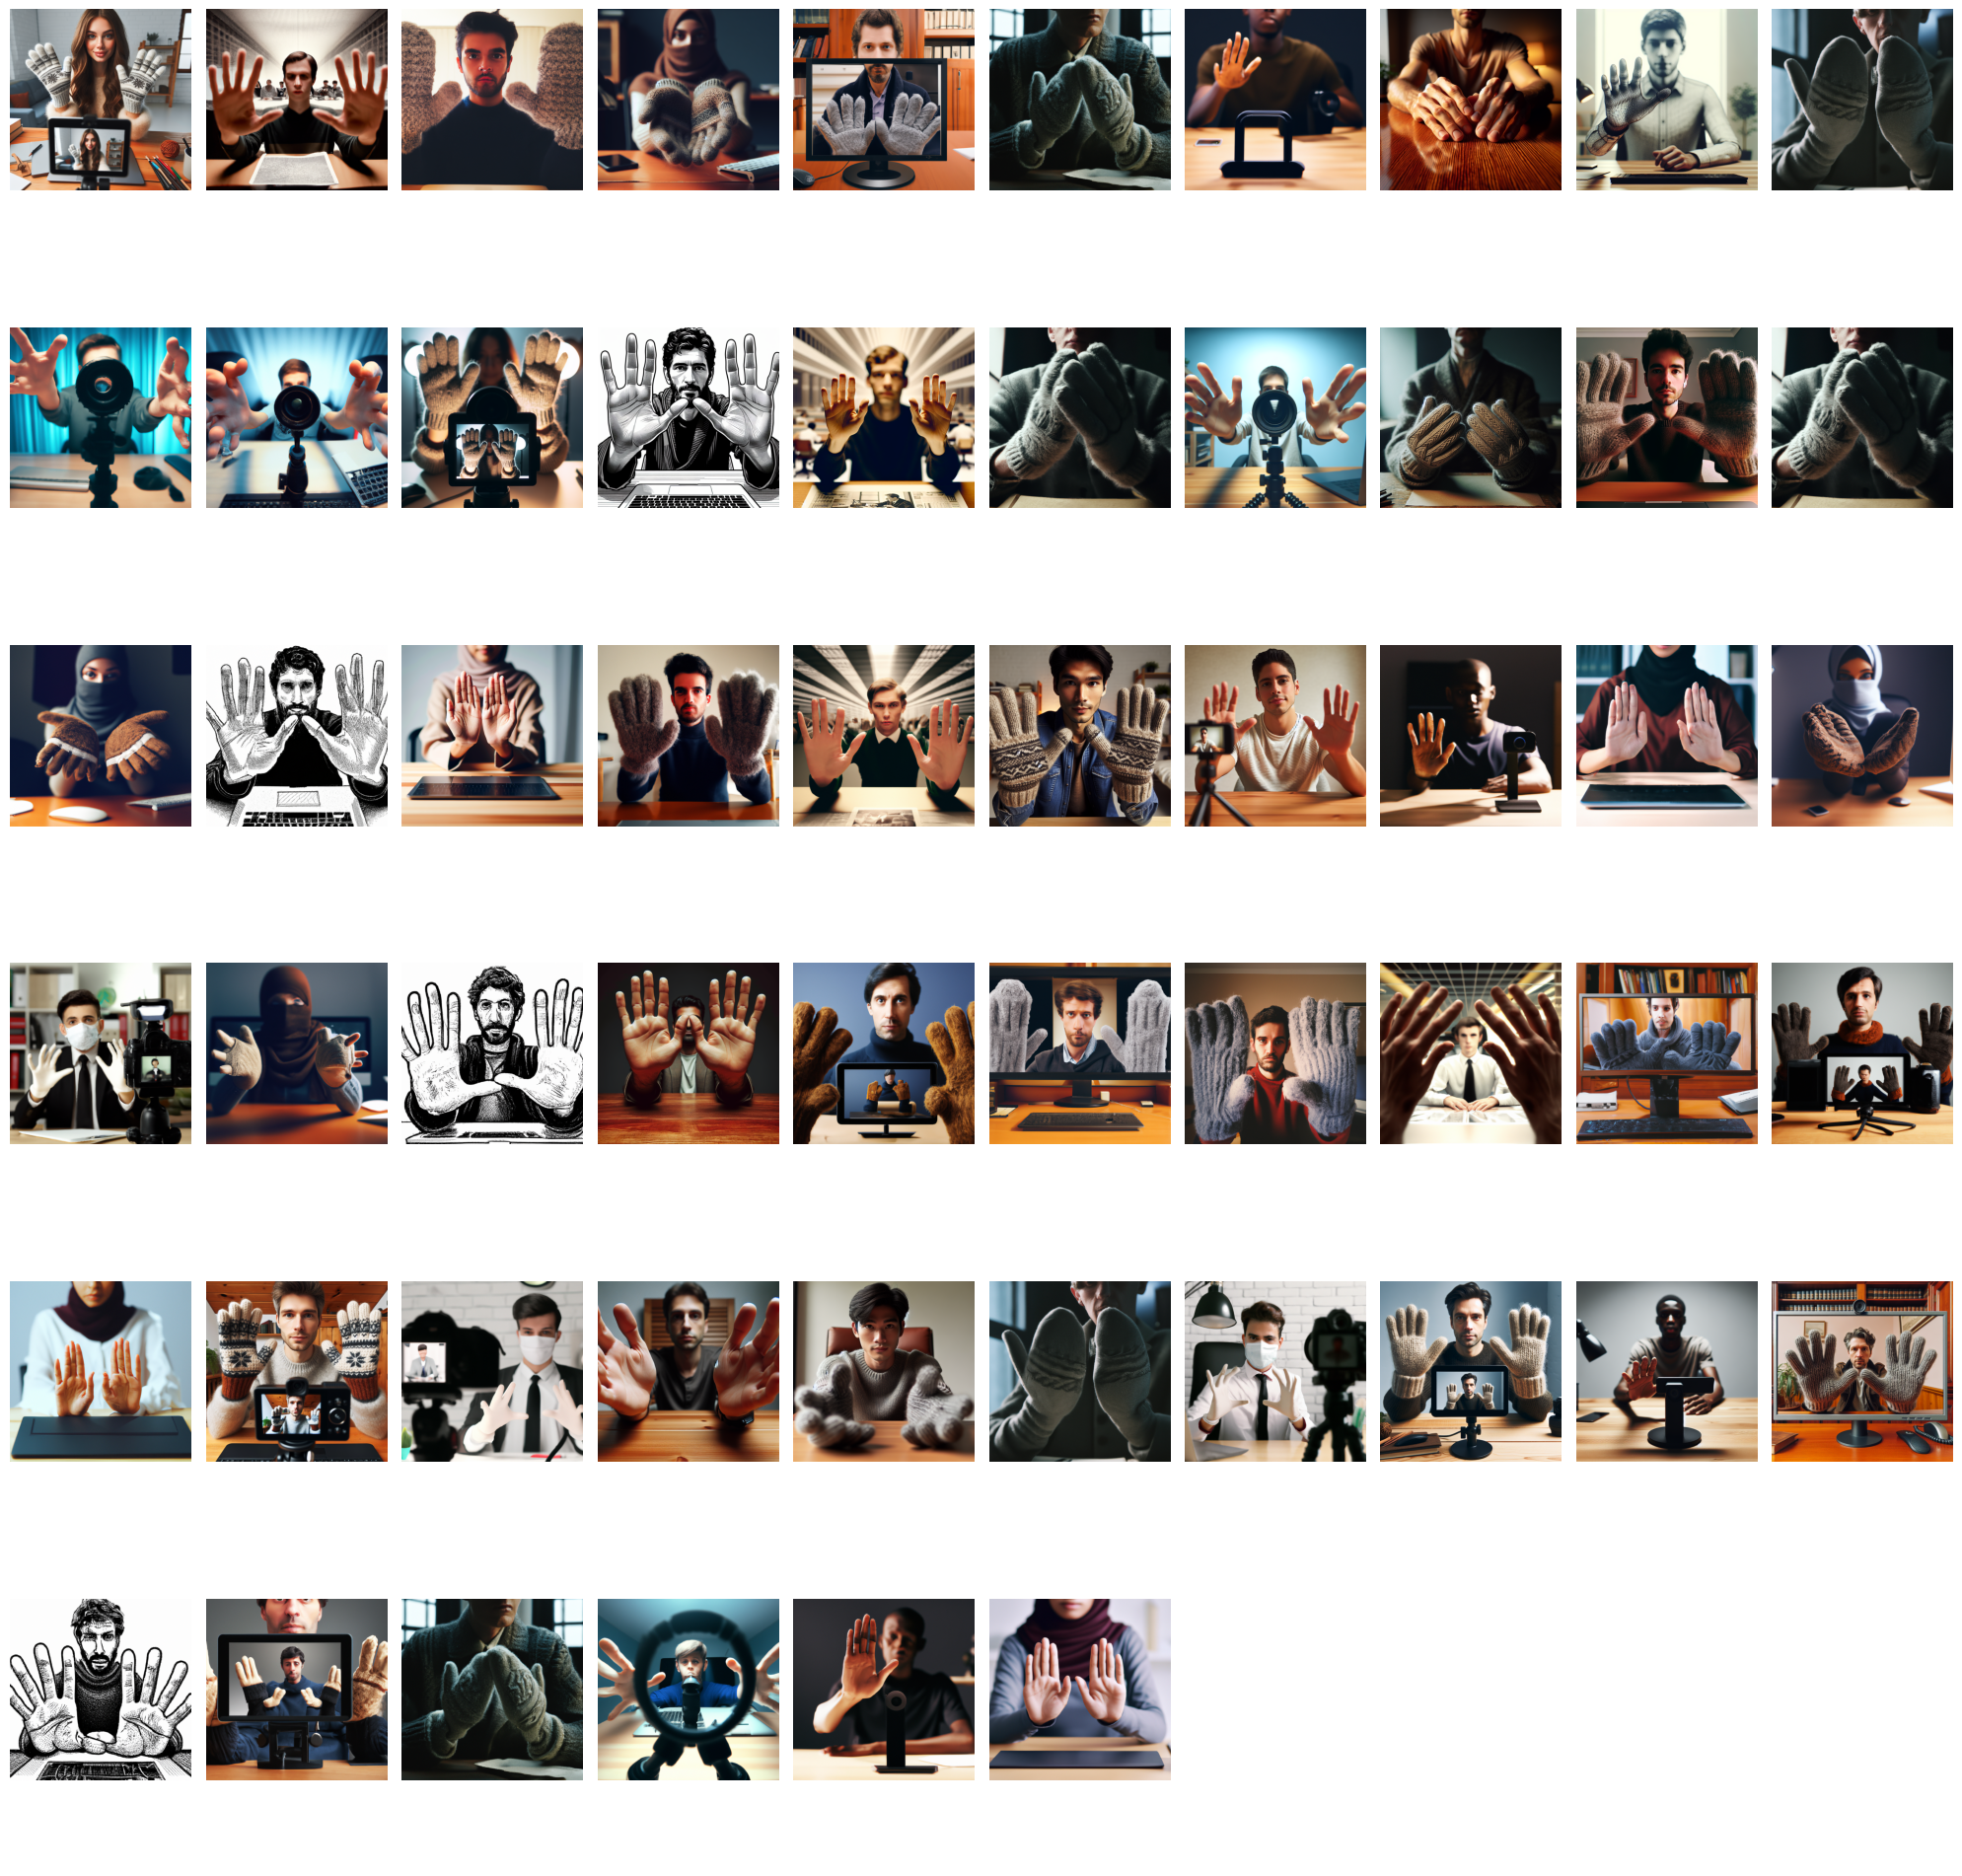

In [17]:
import os


# Define the folder containing the images
folder_path = output_folder

# Get a list of all the image files in the folder
image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith('.png')]
num_images = len(image_files)
print(num_images)
# Set up the plot
ncols = 10
nrows = len(image_files)//ncols + 1
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))

# Loop through each image and plot it in a grid cell
for i in range(nrows - 1):
    for j in range(ncols):
        img = mpimg.imread(os.path.join(folder_path, image_files[i*ncols+j]))
        axs[i,j].imshow(img)
        axs[i,j].axis('off')
for j in range(num_images % ncols):
    img = mpimg.imread(os.path.join(folder_path, image_files[(nrows-1)*ncols+j]))
    axs[nrows-1,j].imshow(img)
    axs[nrows-1,j].axis('off')
for j in range(num_images%ncols, ncols):
    axs[nrows-1,j].axis('off')
    
# Make the plot look clean
fig.subplots_adjust(hspace=0, wspace=0)
plt.tight_layout()
plt.show()


These files can then be uploaded to a project with these commands (run in a separate terminal window):

In [ ]:
! cd output
! edge-impulse-uploader .

(run edge-impulse-uploader --clean if you have used the CLI before to reset the target project)

## What next?
Now you can use your images to create an image classification model on Edge Impulse.

Why not try some other OpenAI calls, 'edit' could be used to take an existing image and translate it into different environments or add different humans to increase the variety of your dataset. https://platform.openai.com/docs/guides/images/usage